In [ ]:
# using google colab
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/in-context-learning/src

Mounted at /content/drive
/content/drive/MyDrive/in-context-learning/src


In [ ]:
# imports and requirements

!pip install -r requirements.txt &> /dev/null

import jax

from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run, gen_orthogonal_design
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

In order to check the number of flops of a model, run the python script with the following command.

In [ ]:
# check number of flops

!python check_flops.py --config conf/linear_regression.yaml


In order to train a model run the python script with the following command. In order to use wandb you need to set up an account. Press 1. after running the following cell.

In [ ]:
#@title Choose task
task = "mixtures" #@param  ["linear_regression", "mixtures", "laplace_linear_regression"]

if task == "linear_regression":
  !python train.py --config conf/linear_regression.yaml
elif task == "mixtures":
  !python train_mixture.py --config conf/mixtures.yaml
elif task == "laplace_linear_regression":
  !python train.py --config conf/noisy_laplace_linear_regression.yaml

In [ ]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name,n_layers,hidden_size
3,linear_regression_with_mean,linear_regression,Transformer,change_mu=False_delta=1_mu=0.586,-1,-1,20,12.0,8.0,linear_regression_mean,-1.0,-1.0
0,experiment_progression,linear_regression,linear_regression_standard,delta=1_mu=0,-1,-1,20,NaN,1.0,linear_regression_standard,NaN,NaN
1,sigma_curriculum,linear_regression,Transformer,delta=1_mu=0,-1,-1,20,12.0,8.0,linear_regression_standard,NaN,NaN
2,standard_curriculum,linear_regression,Transformer,delta=1_mu=0,-1,-1,20,12.0,8.0,linear_regression_standard,NaN,NaN
4,Deep_fully_connected_NN,linear_regression,DNN,change_mu=False_delta=1_mu=0,-1,-1,20,NaN,NaN,linear_regression_standard,8.0,1500.0
5,laplace_with_correlation,laplace_linear_regression,Transformer,delta=1_mu=0_sigma=0.1,-1,-1,20,12.0,8.0,noisy_laplace_linear_regression,NaN,NaN


In [ ]:
task = "linear_regression" #@param  ["linear_regression", "laplace_linear_regression"]


run_id = "Deep_fully_connected_NN"  #@param  ["linear_regression_with_mean", "Deep_fully_connected_NN", "laplace_with_correlation"]

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

_, conf = get_model_from_run(run_path, only_conf=True)
task_kwargs = conf.training.task_kwargs
if recompute_metrics:
    get_run_metrics(run_path, **task_kwargs)  # these are normally precomputed at the end of training

## Plot pre-computed metrics

100%|██████████| 15/15 [00:00<00:00, 90264.79it/s]


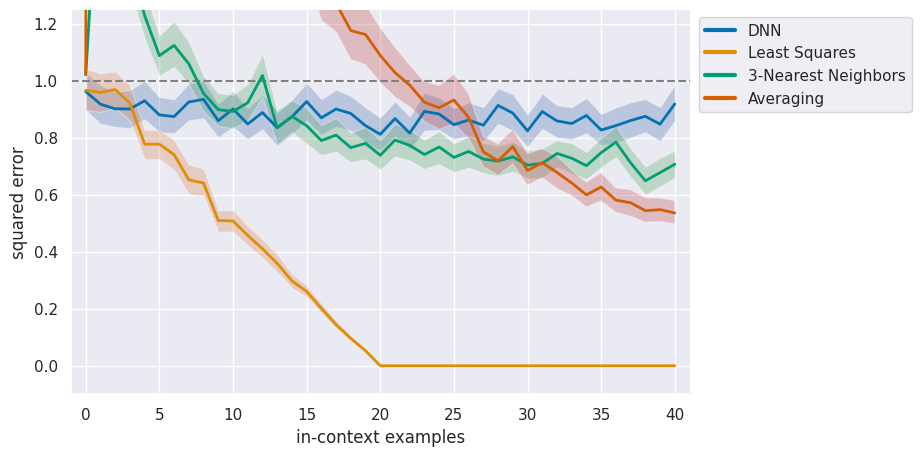

In [ ]:
from plot_utils import relevant_model_names
import matplotlib.pyplot as plt

def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims
models = relevant_model_names[task]
if "Deep_fully_connected_NN"==run_id:
  models = ["DNN",
        "Least Squares",
        "3-Nearest Neighbors",
        "Averaging"]
basic_plot(metrics["standard"], models=models)
plt.show()

<Figure size 800x500 with 0 Axes>

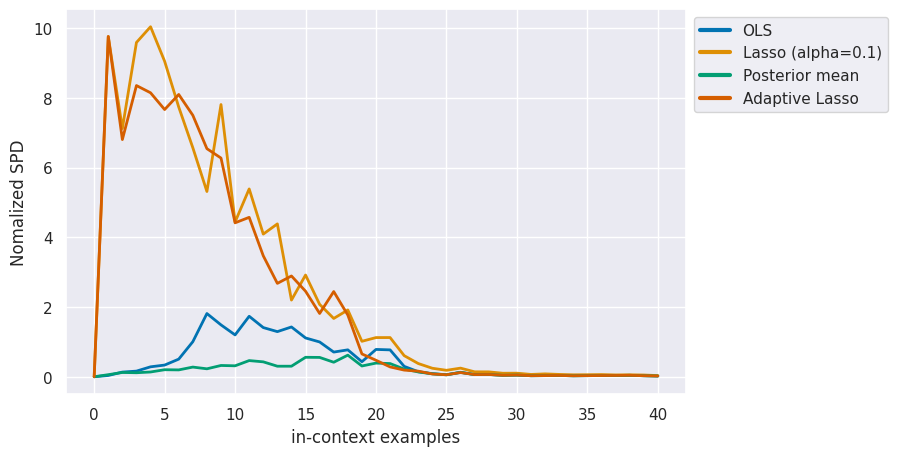

In [ ]:
from utils import plot_SPD_laplace

# SPD analysis is available only for laplace since we saved the predictions only for laplace

folder = "/content/drive/MyDrive/in-context-learning/models/laplace_linear_regression/laplace_with_correlation"
plot_SPD_laplace(folder, n_files=2)

## Test sampling from mixture bernoulli


The following code load models and compute statistics regarding the mixture of Bernoulli experiment.

In [ ]:
from utilities_mixtures import *

n_dims = 5
b_size = 32
n_clusters = 2
n_points = 1000
model, conf = get_model_from_run(f"/content/drive/MyDrive/in-context-learning/models/mixtures/{n_clusters}_clusters_d={n_dims}")

statistics = compute_number_k_clusters(
    b_size, n_clusters, n_dims, n_points, model, lr=0.005, n_batches=25)

print("proportion Transformers", statistics["proportions"]["transformers"])
print("proportion EM", statistics["proportions"]["EM"])
print("proportion PGD", statistics["proportions"]["GD"])

print("average loss Transformers", statistics["losses"]["transformers"])
print("average loss EM", statistics["losses"]["EM"])
print("average loss PGD", statistics["losses"]["GD"])

proportion Transformers 0.0
proportion EM 0.025
proportion PGD 0.07
average loss Transformers 87.454775390625
average loss EM 87.15558532714844
average loss PGD 95.80837615966797


In [ ]:
from utilities_mixtures import *
n_dims = 5
b_size = 32
n_clusters = 3
n_points = 1000
model, conf = get_model_from_run(f"/content/drive/MyDrive/in-context-learning/models/mixtures/{n_clusters}_clusters_d={n_dims}")

statistics = compute_number_k_clusters(
    b_size, n_clusters, n_dims, n_points, model, lr=0.0055, n_batches=25)

print("proportion Transformers", statistics["proportions"]["transformers"])
print("proportion EM", statistics["proportions"]["EM"])
print("proportion PGD", statistics["proportions"]["GD"])

print("average loss Transformers", statistics["losses"]["transformers"])
print("average loss EM", statistics["losses"]["EM"])
print("average loss PGD", statistics["losses"]["GD"])

proportion Transformers 0.0
proportion EM 0.0275
proportion PGD 0.33125
average loss Transformers 93.45814208984375
average loss EM 92.59317749023438
average loss PGD 95.73803649902344


In [ ]:
from utilities_mixtures import *
n_dims = 5
b_size = 32
n_clusters = 4
n_points = 1000
model, conf = get_model_from_run(f"/content/drive/MyDrive/in-context-learning/models/mixtures/{n_clusters}_clusters_d={n_dims}")

statistics = compute_number_k_clusters(
    b_size, n_clusters, n_dims, n_points, model, lr=0.005, n_batches=25)

print("proportion Transformers", statistics["proportions"]["transformers"])
print("proportion EM", statistics["proportions"]["EM"])
print("proportion PGD", statistics["proportions"]["GD"])

print("average loss Transformers", statistics["losses"]["transformers"])
print("average loss EM", statistics["losses"]["EM"])
print("average loss PGD", statistics["losses"]["GD"])

proportion Transformers 0.0
proportion EM 0.0375
proportion PGD 0.54125
average loss Transformers 95.36749176025391
average loss EM 94.7398468017578
average loss PGD 96.99063751220703


In [ ]:
from utilities_mixtures import *
n_dims = 5
b_size = 32
n_clusters = 5
n_points = 1000
model, conf = get_model_from_run(f"/content/drive/MyDrive/in-context-learning/models/mixtures/{n_clusters}_clusters_d={n_dims}")

statistics = compute_number_k_clusters(
    b_size, n_clusters, n_dims, n_points, model, lr=0.0055, n_batches=25)

print("proportion Transformers", statistics["proportions"]["transformers"])
print("proportion EM", statistics["proportions"]["EM"])
print("proportion PGD", statistics["proportions"]["GD"])

print("average loss Transformers", statistics["losses"]["transformers"])
print("average loss EM", statistics["losses"]["EM"])
print("average loss PGD", statistics["losses"]["GD"])

proportion Transformers 0.0
proportion EM 0.05375
proportion PGD 0.7125
average loss Transformers 97.47984252929687
average loss EM 97.2065786743164
average loss PGD 99.37829864501953


## Experiment progression

The following cells show how to train probe models and show error progression.

In [ ]:
from utils import test_errors_layer_by_layer

# given a run path we train subsequent probe models

run_path = os.path.join(run_dir, "linear_regression", "experiment_progression")
test_errors_layer_by_layer(run_path)

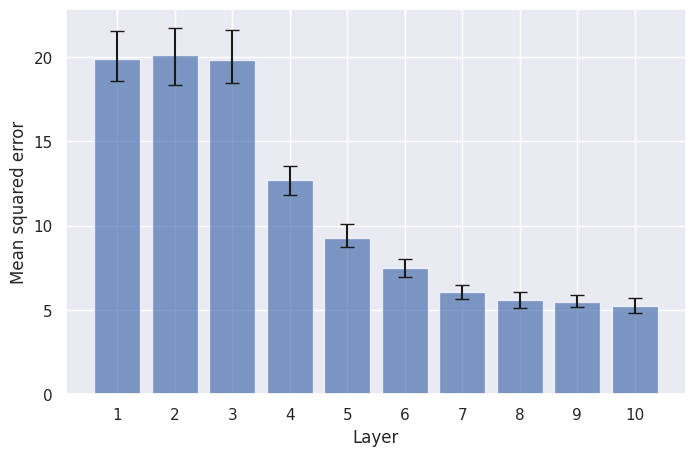

In [ ]:
from plot_utils import plot_errors_layer_by_layer

# plot errors layer by layer

run_path = os.path.join(run_dir, "linear_regression", "experiment_progression")
results_path = os.path.join(run_path, "results")
plot_errors_layer_by_layer(results_path)